# 1. Data preparation
This notebook 
* downloads the used CML dataset [OpenMRG (Andersson et al. 2022)]()
* transform the into a common data format  
* shows some statisitcs and comparisons of the CML and reference data

As result, the cml datasets are ready for processing and the reference data from gauges and radar are already in their final resolution of 15 minutes for evaluation. Radar rainfall along the CML paths is computed.

In [1]:
import sys
import os

# # Add submodules needed for data preparation
sys.path.insert(0, os.path.abspath("./poligrain/src"))
sys.path.insert(0, os.path.abspath("./OPENSENSE_sandbox/notebooks/"))

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import opensense_data_downloader_and_transformer as oddt
import pandas as pd
import poligrain as plg
import pyproj

#### Download OpenMRG dataset with code from [OepnSense sandbox](link) and transform to the data format standards given in [Fencl et al. 2023](https://open-research-europe.ec.europa.eu/articles/3-169).

In [3]:
local_path="data/andersson_2022_OpenMRG/"

# function from OpenSense sandbox 
oddt.download_andersson_2022_OpenMRG(
    local_path=local_path, print_output=True
)

to data/andersson_2022_OpenMRG//OpenMRG.zip


('data/andersson_2022_OpenMRG/OpenMRG.zip',
 <http.client.HTTPMessage at 0x774e9258d850>)

#### Transform CML data

In [4]:
# Transform data in two steps due to memory constraints when transforming the full dataset
# Transform first part of the data
ds1 = oddt.transform_andersson_2022_OpenMRG(
    fn=local_path + "OpenMRG.zip",  # navigate to your local sandbox clone
    path_to_extract_to=local_path,
    time_start_end=(
        None,
        "2015-07-15T00:00",
    ),  # default (None, None) -> no timeslicing. ie. ('2015-08-31T00', None),
    restructure_data=True,
)
# Transform second part of the data
ds2 = oddt.transform_andersson_2022_OpenMRG(
    fn=local_path + "OpenMRG.zip",  # navigate to your local sandbox clone
    path_to_extract_to=local_path,
    time_start_end=(
        "2015-07-15T00:00",
        None,
    ),  # default (None, None) -> no timeslicing. ie. ('2015-08-31T00', None),
    restructure_data=True,
)
# Resample to 1 minute temporal resolution, save memory when merging the two periods loaded above
ds1 = ds1.resample(time="1min").first(skipna=True)
ds2 = ds2.resample(time="1min").first(skipna=True)

# concat and drop overlaying duplicate
ds_cml = xr.concat([ds1, ds2], dim="time").drop_duplicates(dim="time")

/home/erlend/Documents/GitHub/OpenMRG2/OPENSENSE_sandbox/notebooks/opensense_data_downloader_and_transformer.py:302: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'sublink' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds_multindex = ds.assign_coords({'sublink':df_metadata.index})
/home/erlend/Documents/GitHub/OpenMRG2/OPENSENSE_sandbox/notebooks/opensense_data_downloader_and_transformer.py:302: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'sublink' coordinate(s) or data variable(s) will

#### Transform rain gauge data

In [5]:
df_gauges_city = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/city/CityGauges-2015JJA.csv",
    index_col=0,
    parse_dates=True,
)

df_gauges_city_metadata = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/city/CityGauges-metadata.csv",
    index_col=0,
)

In [6]:
ds_gauges_city_org = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["id", "time"], df_gauges_city.T),
    ),
    coords=dict(
        id=df_gauges_city_metadata.index.values,
        time=df_gauges_city.index.values,
        longitude=(["id"], df_gauges_city_metadata.Longitude_DecDeg),
        latitude=(["id"], df_gauges_city_metadata.Latitude_DecDeg),
        location=(["id"], df_gauges_city_metadata.Location),
        type=(["id"], df_gauges_city_metadata.Type),
        quantization=(["id"], df_gauges_city_metadata["Resolution (mm)"]),
    ),
)
ds_gauges_city = ds_gauges_city_org.resample(time="15min", label="right", closed="right").sum()

In [7]:
df_gauge_smhi = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/smhi/GbgA-71420-2015JJA.csv",
    index_col=0,
    parse_dates=True,
)


ds_gauges_smhi = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["id", "time"], [df_gauge_smhi.Pvol_mm.values]),
    ),
    coords=dict(
        id=["SMHI"],
        time=df_gauge_smhi.index.values,
        longitude=(["id"], [11.9924]),
        latitude=(["id"], [57.7156]),
        location=(["id"], ["Goeteburg A"]),
        type=(["id"], ["15 min rainfall sum"]),
        quantization=(["id"], [0.1]),
    ),
)

In [8]:
ds_gauges = xr.concat([ds_gauges_city, ds_gauges_smhi], dim="id")
ds_gauges = ds_gauges.sel(time=slice(ds_cml.time.min(),ds_cml.time.max()))

In [9]:
# ds_gauges=ds_gauges.reindex(time=pd.date_range(
#     "2015-06-01T00:00:00",
#     "2015-08-31T23:45:00",freq="15min"), fill_value=np.nan)

ds_gauges = ds_gauges.rename({"rainfall_amount": "R"})

In [10]:
ds_gauges.to_netcdf('data/andersson_2022_OpenMRG/gauges/openmrg_gauges.nc')

#### Transform radar data

In [11]:
# read radar data and convert to Opensense naming conventions
ds_rad = (
    xr.open_dataset(local_path + "radar/radar.nc")
    .rename( 
        {"lat": "latitudes", "lon": "longitudes"}
    )
    .transpose("time", "y", "x")
)

# Turn into coordinates and fix naming error
ds_rad.coords['latitudes'] = ds_rad.latitudes
ds_rad.coords['longitudes'] = ds_rad.longitudes
ds_rad = ds_rad.rename({"longitudes": "lon", "latitudes": "lat"})

In [12]:
# Apply masrhal palmer to get rainfall rates
ds_rad["rainfall_amount"] = (10 ** (ds_rad.data / 10) / 200) ** (5 / 8)

In [13]:
# flip along y axis to work in the grid intersection function
ds_rad["latitudes"] = (("y", "x"), np.flip(ds_rad.lat.data, axis=0))
ds_rad["rainfall_amount"] = (
    ("time", "y", "x"),
    np.flip(ds_rad.rainfall_amount.data, axis=1),
)

# convert to sum 15 min
ds_rad_15min = ds_rad[['crs', 'lat', 'lon', 'rainfall_amount']].resample(time='15min', label='right', closed='right').sum()*5/60
ds_rad_15min.rainfall_amount.attrs["units"] = "sum 15min"

In [14]:
# saving radar
ds_rad_15min.to_netcdf('data/andersson_2022_OpenMRG/radar/openmrg_rad.nc') 

#### Radar rainfall along CML

In [15]:
da_intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cml.site_0_lon.values,
    y1_line=ds_cml.site_0_lat.values,
    x2_line=ds_cml.site_1_lon.values,
    y2_line=ds_cml.site_1_lat.values,
    cml_id=ds_cml.cml_id.values,
    x_grid=ds_rad_15min.lon.values,
    y_grid=ds_rad_15min.lat.values,
    grid_point_location='center',
)
ds_cml['radar_along_cml'] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad_15min.rainfall_amount,
    intersect_weights=da_intersect_weights,
).resample(time = '1min').bfill()/15

#### Visualize data

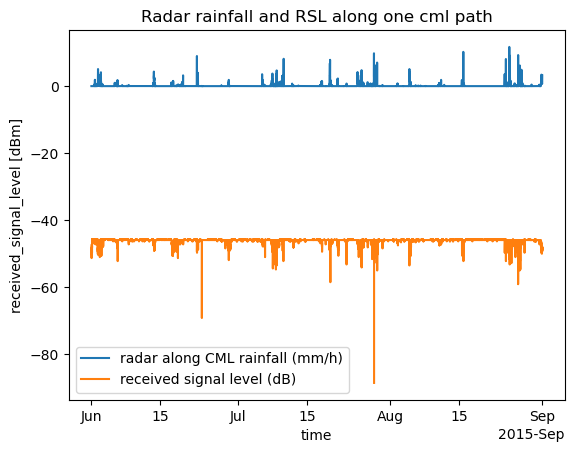

In [16]:
# radar rainfall along one cml path
(ds_cml.radar_along_cml*60).sel(cml_id=10001).plot(label='radar along CML rainfall (mm/h)')
ds_cml.rsl.sel(cml_id=10001,sublink_id='sublink_1').plot(label='received signal level (dB)')
plt.legend()
plt.title('Radar rainfall and RSL along one cml path');

(array([0.        , 0.02416667, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.02416667, 0.02416667, 0.02416667, 0.        ,
        0.02416667, 0.        , 0.02416667, 0.02416667, 0.        ,
        0.        , 0.        , 0.04833333, 0.02416667, 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([180.        , 184.13793103, 188.27586207, 192.4137931 ,
        196.55172414, 200.68965517, 204.82758621, 208.96551724,
        213.10344828, 217.24137931, 221.37931034, 225.51724138,
        229.65517241, 233.79310345, 237.93103448, 242.06896552,
        246.20689655, 250.34482759, 254.48275862, 258.62068966,
        262.75862069, 266.89655172, 271.03448276, 275.17241379,
        279.31034483, 283.44827586, 287.5862069 , 291.72413793,
        295.86206897, 300.        ]),
 <BarContainer object of 29 artists>)

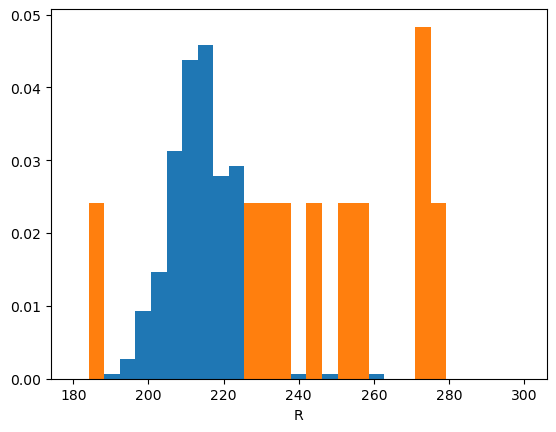

In [17]:
(ds_cml.radar_along_cml.sum(dim='time')).plot.hist(bins=np.linspace(180,300,30), density=True)
ds_gauges.R.sum(dim='time').plot.hist(bins=np.linspace(180,300,30), density=True)

In [18]:
# save CML data
ds_cml.to_netcdf('data/andersson_2022_OpenMRG/openMRG_cml.nc')